In [61]:
import sys
assert sys.version_info >= (3, 5)
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore') # Para evitar los molestos avisos.
%matplotlib inline
from sklearn.preprocessing import StandardScaler

In [62]:
# Indicamos que los tipos de datos float se muestren con 2 decimales
pd.options.display.float_format = '{:.2f}'.format

In [63]:
# Estandarizador (transforma las variables en z-scores)
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [64]:
import utils as ut

In [65]:
DATA_PATH = "../data/union/End"
def load_data_prep(data_path=DATA_PATH):
    csv_path = os.path.join(data_path, "dataset_final.csv")
    return pd.read_csv(csv_path)

### Recordemos que la seleccion de features tenemos 2 grupos:
`efs.best_feature_names_, sbs.k_feature_names_`

`(('ccbd_diameter',
  'sl2l_mean_length',
  'ecpl_mean_length',
  'ccbd_number_of_tracts'),
 ('ccbd_diameter',
  'sl2l_mean_length',
  'ifol_number_of_tracts',
  'ifol_diameter'))`
  ccbd_diameter, sl2l_mean_length, ecpl_mean_length, ccbd_number_of_tracts, ifol_number_of_tracts, ifol_diameter 

In [66]:
df = load_data_prep()

In [67]:
df.head()

,cod,afsl_ad,afsl_area_of_end_region_1,afsl_area_of_end_region_2,afsl_branch_volume,afsl_curl,afsl_diameter,afsl_dti_fa,afsl_elongation,afsl_irregularity,...,ufsr_radius_of_end_region_2,ufsr_rd,ufsr_rdi,ufsr_span,ufsr_total_area_of_end_regions,ufsr_total_radius_of_end_regions,ufsr_total_surface_area,ufsr_trunk_volume,ufsr_volume,label
0,sub-10171,1.24,1471.85,1248.58,11931.50,4.49,16.47,0.46,7.19,7.44,...,9.62,0.77,0.33,8.97,2693.99,18.45,21228.70,9877.95,14154.40,1
1,sub-10189,1.15,2234.71,1009.63,8798.79,3.73,15.07,0.49,6.87,6.82,...,10.13,0.72,0.15,15.11,2108.38,19.15,19638.40,7918.42,11760.10,1
2,sub-10206,1.23,478.87,827.49,1825.37,3.77,11.91,0.47,6.58,5.30,...,8.22,0.83,0.18,10.67,933.25,17.18,12013.70,2729.24,6178.25,1
3,sub-10217,1.19,2978.96,1547.25,1441.49,3.35,17.87,0.46,5.92,7.33,...,8.48,0.74,0.34,9.68,2180.85,17.17,16714.30,10092.40,10799.40,1
4,sub-10225,1.24,1581.53,683.53,7555.11,3.77,15.77,0.46,6.38,6.95,...,12.60,0.83,0.44,10.19,691.37,24.44,13561.00,1653.02,4666.25,1


In [68]:
df1 = df[['ccbd_diameter','sl2l_mean_length','ifol_number_of_tracts', 'ifol_diameter', 'ecpl_mean_length', 'ccbd_number_of_tracts','label']]

In [69]:
df1.shape

(75, 7)

Veamos si balanceando nuestras clases podemos mejorar la performance de nuestro modelo.

## Subsampleo de clase mayoritaria

In [70]:
df3 = df1
df3.label.value_counts()
df3.label.value_counts()/df1.label.count()*100
# Partición en train y test
y = df1.loc[:, df1.columns == 'label']
X = df1.loc[:, df1.columns != 'label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

In [71]:
train = X_train
train['label'] = y_train.label.to_list()

control = train[train.label == 1]
print(len(control))
estudio = train[train.label == 0]
print(len(estudio))
control_sub = control.sample(n=len(estudio), random_state=99)
len(control_sub)
train_sub = pd.concat([estudio, control_sub])
len(train_sub)
y_train = train_sub.loc[:, train_sub.columns == 'label']
X_train = train_sub.loc[:, train_sub.columns != 'label']
X_train.shape, y_train.shape

39
21


((42, 6), (42, 1))

In [72]:
std_scale = StandardScaler() # Creamos el estandarizador para usarlo posteriormente

In [73]:
# Ajustamos el estandarizador
std_scale.fit(X_test)
std_scale.fit(X_train)

# Aplicamos el estandarizador y obtenemos la matriz de features escaleados
X_test_scaled = std_scale.transform(X_test)
X_scaled = std_scale.transform(X_train)

In [74]:
from sklearn.linear_model import LogisticRegression

In [75]:
logreg = LogisticRegression()
logreg.fit(X_scaled, y_train)

LogisticRegression()

In [76]:
y_train_pred = logreg.predict(X_scaled)
y_pred = logreg.predict(X_test_scaled)
print('Accuracy: {:.2f}'.format(logreg.score(X_test_scaled, y_test)))

Accuracy: 0.53


In [77]:
import sklearn.metrics as metrics

In [78]:
y_train_pred.argmax()

1

In [79]:
train_accuracy =  metrics.accuracy_score(y_train_pred,y_train) 
test_accuracy =  metrics.accuracy_score(y_pred, y_test)
print(f'Accuracy en el train set: {train_accuracy:.2f}')
print(f'Accuracy en el test set: {test_accuracy:.2f}')


Accuracy en el train set: 0.50
Accuracy en el test set: 0.53


In [80]:
#!pip install -U --upgrade scikit-learn

In [81]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[2 2]
 [5 6]]


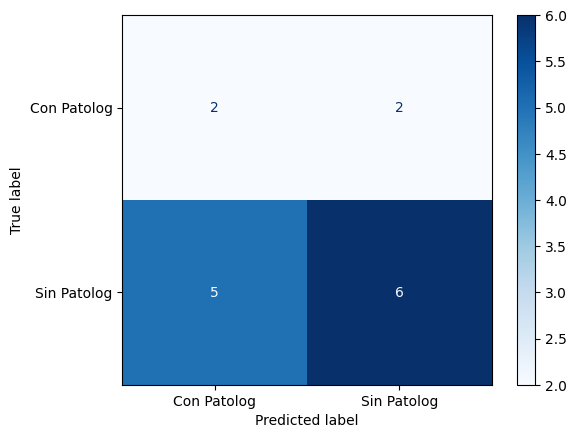

In [82]:
class_names = ['Con Patolog', 'Sin Patolog']
ConfusionMatrixDisplay.from_estimator(logreg, X_test_scaled, y_test, display_labels=class_names, cmap=plt.cm.Blues)
plt.show()


In [83]:
# !pip install -q -U lightgbm
# !pip install -q -U catboost
# !pip install scikit-plot

In [84]:
from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import StandardScaler 

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from lightgbm import LGBMClassifier

In [85]:
from sklearn.model_selection import RandomizedSearchCV

In [86]:
from catboost import CatBoostClassifier
import scipy.stats as st

In [87]:
from sklearn.metrics import accuracy_score, precision_score, recall_score # Accuracy metrics 

In [88]:
EXPORT_PATH = '../data/union/End' # Hay que completar con el path donde se quiere guardar el modelo

In [89]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [90]:
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [91]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import roc_auc_score
from scikitplot.metrics import plot_roc

In [92]:
num_columns = ['ccbd_diameter','sl2l_mean_length','ifol_number_of_tracts', 'ifol_diameter', 'ecpl_mean_length', 'ccbd_number_of_tracts']

In [93]:
# vamos a usar polynomial features sobre las variables numéricas
poly = PolynomialFeatures()
# Las categorías "nuevas" que aparezcan se imputan con el valor de unknown_value
# o_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=99999999)

In [94]:
pipeline = Pipeline([
    ("selector_num", ColumnTransformer(
        [
            ("poly", poly, num_columns)
        ], remainder="passthrough")
    ),
    ("classifier", CatBoostClassifier())
    ]
)

In [95]:
one_to_left = st.beta(10, 1) # Esta distribución nos dará valores entre 0 y 1 mayormente cercanos a 1

In [96]:
# este diccionario de parámetros lo vamos a usar tanto para XGBoost como para LightGBM
params = {  
    "classifier__n_estimators": st.randint(20,150), # n. de árboles.
    "classifier__max_depth": st.randint(3, 12),     # máxima profundiad del árbol
    "classifier__learning_rate": st.uniform(0.05, 0.4), # learning rate (xgb’s “eta”)
    "classifier__colsample_bytree": one_to_left, # ratio de la muestra de las columnas a la hora de construir el árbol
    "classifier__subsample": one_to_left,     # ratio de la muestra de las observaciones
    'classifier__reg_alpha': st.uniform(0.05,10),   # término de regularización L1
    "classifier__min_child_weight": st.uniform(1,20), # Suma mínima del peso de la instancia (hessiano) requerida en los hijos
}

In [97]:
other_params = {"selector_num__poly__degree": [1, 2, 3]}

In [98]:
search_space = [{"classifier": [XGBClassifier(n_jobs=3, eval_metric="logloss", use_label_encoder=False)], 
                 **params,
                 **other_params,
                "classifier__gamma": st.uniform(0, 10), # reducción mínima de la pérdida requerida para hacer un split
                },
                {"classifier": [LGBMClassifier(n_jobs=3, verbose=-1)],
                 **params,
                **other_params},
                {"classifier": [CatBoostClassifier(thread_count=3, verbose=False)],
                 **other_params,
                "classifier__n_estimators": st.randint(20,150), # n. de árboles.
                "classifier__max_depth": st.randint(3, 12),     # máxima profundiad del árbol
                "classifier__learning_rate": st.uniform(0.05, 0.4), # learning rate (xgb’s “eta”)
                "classifier__subsample": one_to_left,     # ratio de la muestra de las observaciones
                },
               {
                   "classifier": [LogisticRegression(max_iter=1000)],
                   "classifier__C": [10**x for x in range(-5, 3)],
               }]

In [99]:
model = RandomizedSearchCV(pipeline, search_space, n_iter=100, verbose=1, cv=3)
model.fit(X_train, y_train)

results = pd.DataFrame(model.cv_results_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [100]:
results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_classifier', 'param_classifier__colsample_bytree',
       'param_classifier__gamma', 'param_classifier__learning_rate',
       'param_classifier__max_depth', 'param_classifier__min_child_weight',
       'param_classifier__n_estimators', 'param_classifier__reg_alpha',
       'param_classifier__subsample', 'param_selector_num__poly__degree',
       'param_classifier__C', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')

In [101]:
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__colsample_bytree,param_classifier__gamma,param_classifier__learning_rate,param_classifier__max_depth,param_classifier__min_child_weight,...,param_classifier__subsample,param_selector_num__poly__degree,param_classifier__C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.01,0.00,0.01,0.00,"XGBClassifier(base_score=None, booster=None, c...",0.93,8.40,0.36,11,10.50,...,0.86,1,NaN,"{'classifier': XGBClassifier(base_score=None, ...",0.50,0.50,0.50,0.50,0.00,49
1,0.02,0.00,0.01,0.00,"XGBClassifier(base_score=None, booster=None, c...",0.92,1.72,0.12,6,6.48,...,0.95,2,NaN,"{'classifier': XGBClassifier(base_score=None, ...",0.50,0.50,0.50,0.50,0.00,49
2,0.02,0.00,0.01,0.00,LogisticRegression(max_iter=1000),NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.00,{'classifier': LogisticRegression(max_iter=100...,0.71,0.43,0.71,0.62,0.13,23
3,0.02,0.00,0.00,0.00,LogisticRegression(max_iter=1000),NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.00,{'classifier': LogisticRegression(max_iter=100...,0.71,0.43,0.71,0.62,0.13,23
4,0.30,0.02,0.00,0.00,<catboost.core.CatBoostClassifier object at 0x...,NaN,NaN,0.16,5,NaN,...,0.78,3,NaN,{'classifier': <catboost.core.CatBoostClassifi...,0.79,0.86,0.64,0.76,0.09,1


In [102]:
# results[['param_classifier', 'mean_test_score']].groupby('param_classifier').mean().sort_values(by='mean_test_score', ascending=False)
results[['param_classifier', 'mean_test_score']]

,param_classifier,mean_test_score
0,"XGBClassifier(base_score=None, booster=None, c...",0.50
1,"XGBClassifier(base_score=None, booster=None, c...",0.50
2,LogisticRegression(max_iter=1000),0.62
3,LogisticRegression(max_iter=1000),0.62
4,<catboost.core.CatBoostClassifier object at 0x...,0.76
...,...,...
95,LogisticRegression(max_iter=1000),0.57
96,"LGBMClassifier(n_jobs=3, verbose=-1)",0.50
97,<catboost.core.CatBoostClassifier object at 0x...,0.74
98,LogisticRegression(max_iter=1000),0.57


In [103]:
model.best_estimator_, model.best_score_

(Pipeline(steps=[('selector_num',
                  ColumnTransformer(remainder='passthrough',
                                    transformers=[('poly',
                                                   PolynomialFeatures(degree=3),
                                                   ['ccbd_diameter',
                                                    'sl2l_mean_length',
                                                    'ifol_number_of_tracts',
                                                    'ifol_diameter',
                                                    'ecpl_mean_length',
                                                    'ccbd_number_of_tracts'])])),
                 ('classifier',
                  <catboost.core.CatBoostClassifier object at 0x0000022B5B97E160>)]),
 0.7619047619047619)

In [104]:
model.best_score_

0.7619047619047619

In [105]:
X_test_ = pd.DataFrame(X_test, columns=['ccbd_diameter','sl2l_mean_length','ifol_number_of_tracts', 'ifol_diameter', 'ecpl_mean_length', 'ccbd_number_of_tracts','label'])

In [106]:
y_predicted = model.predict_proba(X_test_)

<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

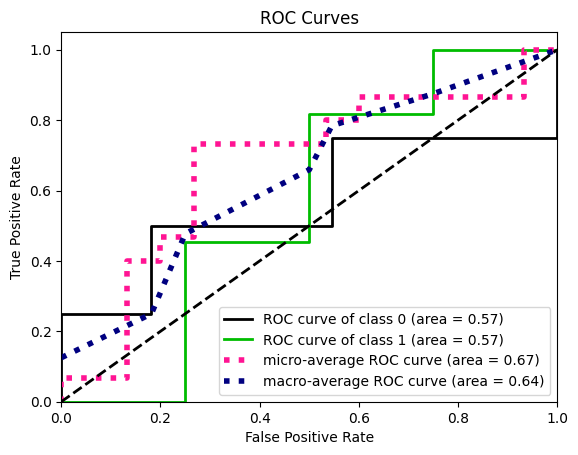

In [107]:
plot_roc(y_test, y_predicted)

In [108]:
roc_auc_score(y_test, y_predicted[:,1])

0.5681818181818181

In [109]:
print(classification_report(y_true=y_test,y_pred=model.predict(X_test_)))

              precision    recall  f1-score   support

           0       0.50      0.50      0.50         4
           1       0.82      0.82      0.82        11

    accuracy                           0.73        15
   macro avg       0.66      0.66      0.66        15
weighted avg       0.73      0.73      0.73        15



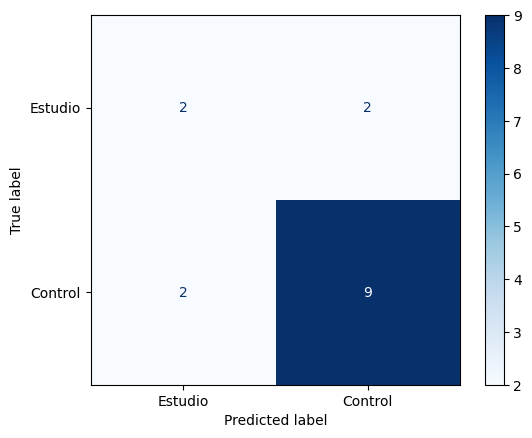

In [110]:
class_names = ['Estudio', 'Control']
ConfusionMatrixDisplay.from_estimator(model, X_test_, y_test, display_labels=class_names, cmap=plt.cm.Blues)
plt.show()

In [111]:
pipelines = {
    'lr':make_pipeline(StandardScaler(), LogisticRegression(penalty = 'l2', class_weight='balanced', max_iter=20000)),
    'rc':make_pipeline(StandardScaler(), RidgeClassifier()),
    'rf':make_pipeline(StandardScaler(), RandomForestClassifier()),
    'gb':make_pipeline(StandardScaler(), GradientBoostingClassifier()),
    'cb':make_pipeline(StandardScaler(), CatBoostClassifier(thread_count=3, verbose=False))}


In [112]:
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__colsample_bytree,param_classifier__gamma,param_classifier__learning_rate,param_classifier__max_depth,param_classifier__min_child_weight,...,param_classifier__subsample,param_selector_num__poly__degree,param_classifier__C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.01,0.00,0.01,0.00,"XGBClassifier(base_score=None, booster=None, c...",0.93,8.40,0.36,11,10.50,...,0.86,1,NaN,"{'classifier': XGBClassifier(base_score=None, ...",0.50,0.50,0.50,0.50,0.00,49
1,0.02,0.00,0.01,0.00,"XGBClassifier(base_score=None, booster=None, c...",0.92,1.72,0.12,6,6.48,...,0.95,2,NaN,"{'classifier': XGBClassifier(base_score=None, ...",0.50,0.50,0.50,0.50,0.00,49
2,0.02,0.00,0.01,0.00,LogisticRegression(max_iter=1000),NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.00,{'classifier': LogisticRegression(max_iter=100...,0.71,0.43,0.71,0.62,0.13,23
3,0.02,0.00,0.00,0.00,LogisticRegression(max_iter=1000),NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.00,{'classifier': LogisticRegression(max_iter=100...,0.71,0.43,0.71,0.62,0.13,23
4,0.30,0.02,0.00,0.00,<catboost.core.CatBoostClassifier object at 0x...,NaN,NaN,0.16,5,NaN,...,0.78,3,NaN,{'classifier': <catboost.core.CatBoostClassifi...,0.79,0.86,0.64,0.76,0.09,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.03,0.01,0.01,0.00,LogisticRegression(max_iter=1000),NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,100,{'classifier': LogisticRegression(max_iter=100...,0.71,0.43,0.57,0.57,0.12,35
96,0.01,0.00,0.01,0.00,"LGBMClassifier(n_jobs=3, verbose=-1)",0.68,NaN,0.41,7,1.72,...,0.98,1,NaN,"{'classifier': LGBMClassifier(n_jobs=3, verbos...",0.50,0.50,0.50,0.50,0.00,49
97,0.06,0.00,0.00,0.00,<catboost.core.CatBoostClassifier object at 0x...,NaN,NaN,0.18,7,NaN,...,0.95,1,NaN,{'classifier': <catboost.core.CatBoostClassifi...,0.79,0.86,0.57,0.74,0.12,5
98,0.02,0.01,0.00,0.00,LogisticRegression(max_iter=1000),NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,10,{'classifier': LogisticRegression(max_iter=100...,0.71,0.43,0.57,0.57,0.12,35


In [113]:
X_train.shape, y_train.shape

((42, 6), (42, 1))

In [114]:
X_= X_train.reset_index()
y_= y_train.reset_index()

In [115]:
X_=X_.drop('index', axis=1)
y_=y_.drop('index', axis=1)

In [116]:
skf = StratifiedKFold(n_splits=3, shuffle=True) # 5 folds es un número típico si tenemos suficientes datos. Pedimos shuffle=True para que sea al azar la separación en subgrupos
skf.get_n_splits(X_, y_) # arma los folds a partir de los datos

# acc_values = [] # aca es donde van a ir a parar los accuracys de cada fold
# pr_sc_values = [] # aca es donde van a ir a parar los accuracys de cada fold
# rc_sc_values = [] # aca es donde van a ir a parar los accuracys de cada fold
# scores = np.array([])     # aca es donde van a ir a parar los scores computados para todos los casos
# indices = np.array([])    # aca es donde van a ir a parar los indices correspondientes a las entradas de scores
fit_models = {}

for algo, pipeline in pipelines.items():
      acc_values = []
      pr_sc_values = [] 
      rc_sc_values = []
      for train_index, test_index in skf.split(X_, y_): # va generando los indices que corresponden a train y test en cada fold
            X_train_, X_test_ = X_.iloc[train_index], X_.iloc[test_index] # arma que es dato de entrenamiento y qué es dato de evaluación
            y_train_, y_test_ = y_.iloc[train_index], y_.iloc[test_index]     # idem con los targets
            
            scaler = StandardScaler() # primero creo un objeto MinMaxScaler. Por defecto, esto normaliza los datos al intervalo [0,1]
            scaler.fit(X_train_) # encuentro los parametros para el escaleo
            X_train_ = scaler.transform(X_train_) # aplico la transformacion

            scaler = StandardScaler() # primero creo un objeto MinMaxScaler. Por defecto, esto normaliza los datos al intervalo [0,1]
            scaler.fit(X_test_) # encuentro los parametros para el escaleo
            X_test_ = scaler.transform(X_test_) # aplico la transformacion
            
            model = pipeline.fit(X_train_, np.ravel(y_train_))
            probas_test = model.predict(X_test_)  # probabilidades con datos de evaluación
            
            acc_test = accuracy_score(y_test_, probas_test)
            pr_sc = precision_score(y_test_.values, probas_test, average="weighted", pos_label=1)
            rc_sc = recall_score(y_test_.values, probas_test, average="weighted", pos_label=1)
            
            acc_values.append(acc_test)
            pr_sc_values.append(pr_sc)
            rc_sc_values.append(rc_sc)
            
            print(algo,'ac-sc: {}'.format(round(accuracy_score(y_test_, probas_test),3)),
                  'pr-sc: {}'.format(round(precision_score(y_test_.values, probas_test, average="weighted", pos_label="arriba"),3)),
                  'rc-sc: {}'.format(round(recall_score(y_test_.values, probas_test, average="weighted", pos_label="arriba"),3)))
      fit_models[algo] = model
            
      print('----------------------------------------------------')
      print('--------------PROMEDIOS--DE--',algo,'-------------------------')
      print('Accuracy {}'.format(round(np.mean(acc_values),3)), 
      'precision_score {}'.format(round(np.mean(pr_sc_values),3)),
      'recall_score {}'.format(round(np.mean(rc_sc_values),3)))
      print('----------------------------------------------------')
      print('----------------------------------------------------')
      # fpr_test, tpr_test, thresholds_test = roc_curve(y_test, probas_test[:,1]) # para plotear curva ROC con datos de entrenamiento
      # auc_test = roc_auc_score(y_test, probas_test[:,1]) #  AUC con datos de evaluación

      # auc_values.append(auc_test)
      # scores = np.concatenate((scores,probas_test[:,1]),axis=0)
      # indices = np.concatenate((indices,test_index),axis=0)
      fit_models[algo] = model

lr ac-sc: 0.286 pr-sc: 0.267 rc-sc: 0.286
lr ac-sc: 0.429 pr-sc: 0.422 rc-sc: 0.429
lr ac-sc: 0.143 pr-sc: 0.111 rc-sc: 0.143
----------------------------------------------------
--------------PROMEDIOS--DE-- lr -------------------------
Accuracy 0.286 precision_score 0.267 recall_score 0.286
----------------------------------------------------
----------------------------------------------------
rc ac-sc: 0.214 pr-sc: 0.15 rc-sc: 0.214
rc ac-sc: 0.714 pr-sc: 0.733 rc-sc: 0.714
rc ac-sc: 0.429 pr-sc: 0.422 rc-sc: 0.429
----------------------------------------------------
--------------PROMEDIOS--DE-- rc -------------------------
Accuracy 0.452 precision_score 0.435 recall_score 0.452
----------------------------------------------------
----------------------------------------------------
rf ac-sc: 0.571 pr-sc: 0.769 rc-sc: 0.571
rf ac-sc: 0.571 pr-sc: 0.606 rc-sc: 0.571
rf ac-sc: 0.643 pr-sc: 0.646 rc-sc: 0.643
----------------------------------------------------
--------------PROMEDIO

In [117]:
      print('----------------------------------------------------')
      print('--------------PROMEDIOS--DE--',algo,'-------------------------')
      print('Accuracy {}'.format(round(np.mean(acc_values),3)), 
      'precision_score {}'.format(round(np.mean(pr_sc_values),3)),
      'recall_score {}'.format(round(np.mean(rc_sc_values),3)))
      print('----------------------------------------------------')
      print('----------------------------------------------------')

----------------------------------------------------
--------------PROMEDIOS--DE-- cb -------------------------
Accuracy 0.571 precision_score 0.532 recall_score 0.571
----------------------------------------------------
----------------------------------------------------


In [118]:
X_test = X_test.values

In [119]:
y_predicted = fit_models['cb'].predict_proba(X_test)

In [120]:
y_predicted

array([[0.25718394, 0.74281606],
       [0.25718394, 0.74281606],
       [0.25718394, 0.74281606],
       [0.25718394, 0.74281606],
       [0.25718394, 0.74281606],
       [0.25718394, 0.74281606],
       [0.25718394, 0.74281606],
       [0.25718394, 0.74281606],
       [0.25718394, 0.74281606],
       [0.25718394, 0.74281606],
       [0.25718394, 0.74281606],
       [0.25718394, 0.74281606],
       [0.25718394, 0.74281606],
       [0.25718394, 0.74281606],
       [0.25718394, 0.74281606]])